In [401]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

In [402]:
def read_data(file_path: str | Path, sheet: str) -> pd.DataFrame:
    
    # --- Resolve and read ---
    file_path = Path(file_path).expanduser().resolve()
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
        
    df = pd.read_excel(file_path, sheet_name=sheet)
    
    # --- Locate date column ---
    date_col = next((c for c in df.columns if str(c).strip().lower() in {"date", "dates"}), None)
    if date_col is None:
        raise ValueError("No 'Date' or 'Dates' column found in the sheet.")
    
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
    
    # --- Normalize column names (e.g. '_1 Comdty' → 'F1') ---
    rename_map = {}
    for c in df.columns:
        s = str(c).strip()
        
        # Case 1: Bloomberg style "BAP1 Comdty"
        if match := re.search(r"(\d+)\s*Comdty$", s, re.IGNORECASE):
            rename_map[c] = f"F{match.group(1)}"
        # Case 2: Already short or clean ("F1", "M1", "1")
        elif match := re.fullmatch(r"[FfMm]?(\d+)", s):
            rename_map[c] = f"F{match.group(1)}"
    
    df = df.rename(columns=rename_map)
    
    # --- Keep and order tenor columns ---
    tenor_cols = sorted(
        [c for c in df.columns if re.fullmatch(r"F\d+", c)],
        key=lambda x: int(x[1:])
    )
    
    if not tenor_cols:
        raise ValueError("No tenor columns detected (expected headers like 'F1', 'F2', ...).")
    
    df = df[tenor_cols]
    
    return df

WTI = read_data("../data/Commods.xlsx", "WTI (class)")
print(WTI.head())

                F1      F2      F3      F4
Dates                                     
2010-01-04 81.5100 82.1200 82.6500 83.1200
2010-01-05 81.7700 82.4100 82.9900 83.5200
2010-01-06 83.1800 83.7500 84.3100 84.8600
2010-01-07 82.6600 83.1900 83.7500 84.2900
2010-01-08 82.7500 83.3000 83.8700 84.4700


In [403]:
def drop_dupes(df: pd.DataFrame, n: int = 12, decimals: int = 6) -> pd.DataFrame:
    df = df.sort_index()
    cols = [c for c in df.columns if re.fullmatch(r"F\d+", str(c))]
    front = [c for c in cols if int(c[1:]) <= n]

    keys = df[front].round(decimals).agg(tuple, axis=1)
    dup_mask = keys == keys.shift(1)          # True if same as previous
    keep_mask = ~dup_mask | dup_mask.shift(-1).fillna(False)  # keep later of pair

    cleaned = df.loc[keep_mask].copy()
    cleaned.index = pd.to_datetime(cleaned.index)
    return cleaned


In [404]:
# constrain and select time series
start = "2010-01-04"
end   = "2023-12-31"

WTI = WTI.loc[start:end]

# WTI = drop_dupes(WTI)

print("Constrained WTI shape:", WTI.shape)
print(WTI.head())


Constrained WTI shape: (3524, 4)
                F1      F2      F3      F4
Dates                                     
2010-01-04 81.5100 82.1200 82.6500 83.1200
2010-01-05 81.7700 82.4100 82.9900 83.5200
2010-01-06 83.1800 83.7500 84.3100 84.8600
2010-01-07 82.6600 83.1900 83.7500 84.2900
2010-01-08 82.7500 83.3000 83.8700 84.4700


In [405]:
def expiry_calendar(ticker: str, calendar_path: str | Path = "../data/expiry_calendars.xlsx") -> pd.DatetimeIndex:

    df = pd.read_excel(calendar_path, header=0)
    ticker = ticker.upper().strip()

    if ticker not in df.columns:
        raise ValueError(f"Ticker '{ticker}' not found in expiry calendar file.")

    # Drop NaNs and convert to datetime
    expiries = pd.to_datetime(df[ticker].dropna().astype(str), errors='coerce')
    expiries = expiries.dropna().sort_values().unique()

    return pd.DatetimeIndex(expiries)

In [406]:
import numpy as np
import pandas as pd

def rolling_pnl(
    prices: pd.DataFrame,
    expiry_calendar: pd.DatetimeIndex,
    front_col: str = "F1",
    next_col: str = "F2",
    roll_window: int = 6,
) -> pd.DataFrame:

    df = prices.copy()
    idx = df.index

    # --- Guard rails ---
    expiry_calendar = pd.DatetimeIndex(expiry_calendar).sort_values().unique()
    if len(expiry_calendar) == 0:
        raise ValueError("Expiry calendar is empty.")
    last_date = idx.values[-1]

    # --- Map each date to the next expiry (>= date) ---
    next_exp_idx = np.searchsorted(expiry_calendar.values, idx.values, side="left")
    next_exp_idx = np.clip(next_exp_idx, 0, len(expiry_calendar) - 1)

    # If date is strictly after the matched expiry, bump to the following one (unless at end)
    after_mask = idx.values > expiry_calendar.values[next_exp_idx]
    next_exp_idx = next_exp_idx + after_mask.astype(int)
    final_idx = len(expiry_calendar) - 1
    next_exp_idx[next_exp_idx > final_idx] = final_idx  # cap

    # --- Identify the actual next-expiry date for each row ---
    next_exp_dates = expiry_calendar.values[next_exp_idx]

    # --- Position of that next expiry in the trading index ---
    exp_pos = np.searchsorted(idx.values, next_exp_dates, side="left")

    # --- dte: expiry day = 1 ---
    dte = (exp_pos - np.arange(len(idx))) + 1
    dte = dte.astype(float)

    has_in_sample_next = next_exp_dates <= last_date
    dte[~has_in_sample_next] = np.inf

    df["days_to_expiry"] = dte

    # --- Price arrays ---
    f1 = df[front_col].to_numpy()
    f2 = df[next_col].to_numpy()

    pnl = np.zeros(len(df))
    held = np.empty(len(df), dtype=object)

    # --- Flags (Excel aligned) ---
    roll_window_flag = (dte <= roll_window) & (dte > 1) & np.isfinite(dte)
    roll_day_flag = ((dte == roll_window) & np.isfinite(dte)).astype(int)
    post_expiry_flag = np.zeros(len(df), dtype=int)

    # --- Main loop ---
    held[0] = "F1"

    for t in range(1, len(df)):
        dte_y = dte[t - 1]

        if np.isfinite(dte_y):
            # post expiry = first day after expiry
            if dte_y == 1:
                post_expiry_flag[t] = 1

        # --- Pure price PnL (no costs) ---
        if np.isfinite(dte_y) and dte_y == 1:
            # day after expiry: jump from old F2 to new F1
            pnl[t] = f1[t] - f2[t - 1]
            held[t] = "F1"
        elif np.isfinite(dte_y) and dte_y <= roll_window:
            # inside roll window, hold F2
            pnl[t] = f2[t] - f2[t - 1]
            held[t] = "F2"
        else:
            # normal days
            pnl[t] = f1[t] - f1[t - 1]
            held[t] = "F1"

    # --- Finalize ---
    df["daily_pnl"] = pnl
    df["held_contract"] = held
    df["roll_window_flag"] = roll_window_flag.astype(int)
    df["roll_day_flag"] = roll_day_flag
    df["post_expiry_flag"] = post_expiry_flag

    # Interface consistency
    df["t_cost"] = 0.0
    df["net_pnl"] = df["daily_pnl"]

    return df



In [407]:
# Suppose your WTI DataFrame looks like this:
# index = trading dates
# columns = ['M1', 'M2', 'M3', 'M4', ...]

wti_df = WTI.copy()  # your actual dataframe

# Get expiry calendar from our earlier function
expiry = expiry_calendar("CL")

# Compute PnL for M1-M2 roll, 6 days before expiry, with $0.01/bbl cost
rolled = rolling_pnl(
    wti_df,
    expiry_calendar=expiry,
    front_col="F1",
    next_col="F2",
    roll_window=6,
)

# Preview
rolled[["F1", "F2", "days_to_expiry", "daily_pnl", "t_cost", "net_pnl"]].head(40)


,F1,F2,days_to_expiry,daily_pnl,t_cost,net_pnl
Dates,,,,,,
2010-01-04,81.5100,82.1200,12.0000,0.0000,0.0000,0.0000
2010-01-05,81.7700,82.4100,11.0000,0.2600,0.0000,0.2600
2010-01-06,83.1800,83.7500,10.0000,1.4100,0.0000,1.4100
2010-01-07,82.6600,83.1900,9.0000,-0.5200,0.0000,-0.5200
2010-01-08,82.7500,83.3000,8.0000,0.0900,0.0000,0.0900
2010-01-11,82.5200,83.0100,7.0000,-0.2300,0.0000,-0.2300
2010-01-12,80.7900,81.1700,6.0000,-1.7300,0.0000,-1.7300
2010-01-13,79.6500,80.0400,5.0000,-1.1300,0.0000,-1.1300
2010-01-14,79.3900,79.8800,4.0000,-0.1600,0.0000,-0.1600


In [408]:
import numpy as np
import pandas as pd

def roll_EL(
    rolled_df: pd.DataFrame,
    prices: pd.DataFrame,
    front_col: str = "F1",
    t_cost: float = 0.01,
) -> pd.DataFrame:

    if "daily_pnl" not in rolled_df.columns or "roll_day_flag" not in rolled_df.columns:
        raise ValueError("rolled_df must come from rolling_pnl() (needs daily_pnl & roll_day_flag).")

    df = rolled_df.copy()
    idx = df.index
    n = len(df)
    df["t_cost"] = 0.0

    # --- Entry and exit costs (1× each) ---
    df.loc[idx[0], "t_cost"] -= abs(t_cost)
    df.loc[idx[-1], "t_cost"] -= abs(t_cost)

    # --- Per-roll costs (2× each roll, applied pre-roll) ---
    roll_idxs = np.flatnonzero(df["roll_day_flag"].values == 1)
    for r in roll_idxs:
        target = max(0, r - 1)  # pre-roll day
        df.iat[target, df.columns.get_loc("t_cost")] -= 2.0 * abs(t_cost)

    # --- Build equity line ---
    eq = np.zeros(n)
    eq[0] = prices.at[idx[0], front_col] + df.iat[0, df.columns.get_loc("t_cost")]

    for i in range(1, n):
        eq[i] = eq[i - 1] + df.iat[i, df.columns.get_loc("daily_pnl")] + df.iat[i, df.columns.get_loc("t_cost")]

    df["equity_line"] = np.round(eq, 8)
    df["net_pnl"] = df["daily_pnl"] + df["t_cost"]

    return df


In [409]:
# Build equity line
rolled_EL = roll_EL(rolled_df=rolled, prices=wti_df, front_col="F1", t_cost=0.01)

# Preview results
rolled_EL[["F1", "F2", "net_pnl", "equity_line"]].head(20)

,F1,F2,net_pnl,equity_line
Dates,,,,
2010-01-04,81.5100,82.1200,-0.0100,81.5000
2010-01-05,81.7700,82.4100,0.2600,81.7600
2010-01-06,83.1800,83.7500,1.4100,83.1700
2010-01-07,82.6600,83.1900,-0.5200,82.6500
2010-01-08,82.7500,83.3000,0.0900,82.7400
2010-01-11,82.5200,83.0100,-0.2500,82.4900
2010-01-12,80.7900,81.1700,-1.7300,80.7600
2010-01-13,79.6500,80.0400,-1.1300,79.6300
2010-01-14,79.3900,79.8800,-0.1600,79.4700


In [410]:
# ---------------------------------------------------------------------
# Compute metrics (replaces RollingEquity class)
# ---------------------------------------------------------------------
def metrics(df: pd.DataFrame, contracts=1, units=1000) -> pd.Series:
    """
    Compute standardized performance metrics for a rolling strategy.
    Requires df to include 'net_pnl' and 't_cost' columns (from roll_EL()).
    """
    if "net_pnl" not in df.columns or "t_cost" not in df.columns:
        raise ValueError("DataFrame must include 'net_pnl' and 't_cost'.")

    idx = df.index
    years = (idx[-1] - idx[0]).days / 365
    obs_per_year = len(idx) / years if years > 0 else np.nan
    sqrt_af = np.sqrt(obs_per_year) if obs_per_year > 0 else np.nan

    total_pnl = df["net_pnl"].sum() * contracts * units
    total_cost = df["t_cost"].sum() * contracts * units
    apl_unit = (total_pnl / (contracts * units)) / years if years > 0 else np.nan

    daily_std = df["net_pnl"].std()
    ann_std = daily_std * np.sqrt(250)
    sharpe = apl_unit / ann_std if ann_std and ann_std != 0 else np.nan

    pnl_index = 100 + df["net_pnl"].cumsum()
    roll_max = pnl_index.cummax()
    drawdown = (pnl_index / roll_max - 1.0).min()
    rod = -apl_unit / drawdown if drawdown and drawdown != 0 else np.nan

    out = pd.Series({
        "Total PnL": round(total_pnl, 2),
        "Total Cost": round(total_cost, 2),
        "APL/unit": round(apl_unit, 4),
        "Std Dev (ann.)": round(ann_std, 4),
        "Sharpe": round(sharpe, 2),
        "Drawdown": round(drawdown, 4),
        "RoD": round(rod, 2),
        "Years": round(years, 2),
    })

    print("\n--- Debug cost reconciliation ---")
    print(f"t_cost sum inside df: {df['t_cost'].sum():.4f}")
    print(f"Total cost (contracts×units): {total_cost:,.2f}")
    print(f"Total PnL (sum of net_pnl): {total_pnl:,.2f}")

    return out


# ---------------------------------------------------------------------
# RollingStrategy: now just orchestrates pnl → equity → metrics
# ---------------------------------------------------------------------
class RollingStrategy:
    def __init__(self, prices, expiry_calendar, front_col="F1", next_col="F2"):
        self.prices = prices
        self.expiry_calendar = expiry_calendar
        self.front_col = front_col
        self.next_col = next_col
        self._rolled = None
        self._equity = None

    def pnl(self, roll_window=6):
        """Compute pure price-based rolling PnL (no costs)."""
        self._rolled = rolling_pnl(
            self.prices,
            self.expiry_calendar,
            front_col=self.front_col,
            next_col=self.next_col,
            roll_window=roll_window,
        )
        return self._rolled

    def equity(
        self,
        roll_window=6,
        t_cost=0.01,
    ):
        """Apply costs and construct equity line."""
        rolled = self._rolled if self._rolled is not None else self.pnl(roll_window)
        self._equity = roll_EL(
            rolled,
            self.prices,
            front_col=self.front_col,
            t_cost=t_cost,
        )
        return self._equity

    def metrics(self, contracts=1, units=1000):
        """Compute summary statistics using global metrics()."""
        if self._equity is None:
            raise ValueError("Must call .equity() before .metrics().")
        return metrics(self._equity, contracts=contracts, units=units)

# ---------------------------------------------------------------------
# Optional global display tweak
# ---------------------------------------------------------------------
pd.options.display.float_format = "{:,.4f}".format


In [411]:
import os

# Run the pipeline (your current setup)
expiry = expiry_calendar("CL")
WTI = RollingStrategy(wti_df, expiry)
equity_df = WTI.equity(roll_window=6, t_cost=0.01)
results = metrics(equity_df, contracts=100, units=1000)
print(results)

# ---------------------------------------------------------------
# Export full diagnostic DataFrame for manual inspection
# ---------------------------------------------------------------
cols_to_export = [
    "F1", "F2",
    "days_to_expiry", "roll_day_flag", "post_expiry_flag",
    "daily_pnl", "net_pnl", "equity_line",
]

# keep any other tenor columns if present
for c in wti_df.columns:
    if c not in cols_to_export and c.startswith("F"):
        cols_to_export.insert(2, c)



--- Debug cost reconciliation ---
t_cost sum inside df: -3.3800
Total cost (contracts×units): -338,000.00
Total PnL (sum of net_pnl): -5,167,000.00
Total PnL        -5,167,000.0000
Total Cost         -338,000.0000
APL/unit                 -3.6929
Std Dev (ann.)           24.6624
Sharpe                   -0.1500
Drawdown                 -1.2432
RoD                      -2.9700
Years                    13.9900
dtype: float64


In [412]:
import pandas as pd
import numpy as np

def carry(
    prices: pd.DataFrame,
    rolled_df: pd.DataFrame,
    front_col: str = "F1",
    end_col: str = "F4",
    t_cost: float = 0.01,
    epsilon: float = 0.0,
) -> pd.DataFrame:
    df = prices.copy()
    diff = df[front_col] - df[end_col]
    df["signal"] = np.where(diff > epsilon, 1, np.where(diff < -epsilon, -1, 0))

    pnl_df = rolled_df[["daily_pnl", "t_cost", "roll_day_flag"]].copy()
    pnl_df["signal"] = df["signal"].reindex(pnl_df.index).ffill().fillna(0)
    pnl_df["signal_lag"] = pnl_df["signal"].shift(1).fillna(0)
    pnl_df["carry_raw"] = pnl_df["signal_lag"] * pnl_df["daily_pnl"]

    delta = (pnl_df["signal"] - pnl_df["signal"].shift(1)).abs().fillna(0)
    pnl_df["sig_cost_mult"] = np.select([delta == 0, delta == 1, delta == 2], [0, 1, 2], default=0)
    roll_mult = pnl_df["roll_day_flag"] * 2

    combined = np.maximum(pnl_df["sig_cost_mult"], roll_mult)
    flat_overlap = (pnl_df["roll_day_flag"] == 1) & (pnl_df["signal_lag"] != 0) & (pnl_df["signal"] == 0)
    combined[flat_overlap] = 1
    pnl_df["total_cost_mult"] = combined

    if len(pnl_df) > 0:
        pnl_df.iloc[0, pnl_df.columns.get_loc("total_cost_mult")] = max(pnl_df.iloc[0]["total_cost_mult"], 1)
        pnl_df.iloc[-1, pnl_df.columns.get_loc("total_cost_mult")] = max(pnl_df.iloc[-1]["total_cost_mult"], 1)

    pnl_df["total_cost_mult"] = pnl_df["total_cost_mult"].clip(upper=2)
    pnl_df["sig_t_cost"] = pnl_df["total_cost_mult"] * t_cost
    pnl_df["t_cost"] = pnl_df["sig_t_cost"] + rolled_df["t_cost"].reindex(pnl_df.index).fillna(0)
    pnl_df["net_pnl"] = pnl_df["carry_raw"] - pnl_df["t_cost"]
    pnl_df["equity_line"] = pnl_df["net_pnl"].cumsum()

    pnl_df = pnl_df.rename(columns={"carry_raw": "daily_pnl", "roll_day_flag": "roll_flag"})[
        ["daily_pnl", "t_cost", "net_pnl", "roll_flag", "equity_line"]
    ]

    return pnl_df

In [413]:
# Re-run the cell that defines carry() here, then:

carry_df = carry(
    prices=wti_df,
    rolled_df=rolled,
    front_col="F1",
    end_col="F4",
    t_cost=0.01,
    epsilon=0.00,
)

metrics_out = metrics(
    df=carry_df,
    contracts=100,
    units=1000,
)

print("\n----- Carry Strategy Metrics -----")
print(metrics_out)




--- Debug cost reconciliation ---
t_cost sum inside df: 4.9800
Total cost (contracts×units): 498,000.00
Total PnL (sum of net_pnl): 9,545,000.00

----- Carry Strategy Metrics -----
Total PnL        9,545,000.0000
Total Cost         498,000.0000
APL/unit                 6.8219
Std Dev (ann.)          24.6472
Sharpe                   0.2800
Drawdown                -0.2913
RoD                     23.4200
Years                   13.9900
dtype: float64


In [414]:
import pandas as pd
import numpy as np


def momentum(
    prices: pd.DataFrame,
    rolled_df: pd.DataFrame,
    front_col: str = "F1",
    short_ma: int = 1,
    long_ma: int = 20,
    t_cost: float = 0.01,
    epsilon: float = 0.0,
) -> pd.DataFrame:
    df = prices.copy()
    short_avg = df[front_col].rolling(window=short_ma, min_periods=short_ma).mean()
    long_avg = df[front_col].rolling(window=long_ma, min_periods=long_ma).mean()
    diff = short_avg - long_avg
    df["signal"] = np.where(diff > epsilon, 1, np.where(diff < -epsilon, -1, 0))

    pnl_df = rolled_df[["daily_pnl", "t_cost", "roll_day_flag"]].copy()
    pnl_df["signal"] = df["signal"].reindex(pnl_df.index).ffill()
    pnl_df["signal_lag"] = pnl_df["signal"].shift(1).fillna(0)

    start_date = df.index[long_ma - 1] if len(df) >= long_ma else df.index[0]
    pnl_df.loc[pnl_df.index < start_date, ["signal", "signal_lag"]] = 0
    pnl_df.loc[pnl_df.index < start_date, "roll_day_flag"] = 0

    pnl_df["mom_raw"] = pnl_df["signal_lag"] * pnl_df["daily_pnl"]

    delta = (pnl_df["signal"] - pnl_df["signal"].shift(1)).abs().fillna(0)
    pnl_df["sig_cost_mult"] = np.select(
        [delta == 0, delta == 1, delta == 2], [0, 1, 2], default=0
    )
    roll_mult = pnl_df["roll_day_flag"] * 2
    combined = np.maximum(pnl_df["sig_cost_mult"], roll_mult)
    flat_overlap = (
        (pnl_df["roll_day_flag"] == 1)
        & (pnl_df["signal_lag"] != 0)
        & (pnl_df["signal"] == 0)
    )
    combined[flat_overlap] = 1
    pnl_df["total_cost_mult"] = combined

    if not pnl_df.empty:
        pnl_df.iloc[0, pnl_df.columns.get_loc("total_cost_mult")] = max(
            pnl_df.iloc[0]["total_cost_mult"], 1
        )
        pnl_df.iloc[-1, pnl_df.columns.get_loc("total_cost_mult")] = max(
            pnl_df.iloc[-1]["total_cost_mult"], 1
        )

    pnl_df["total_cost_mult"] = pnl_df["total_cost_mult"].clip(upper=2)
    pnl_df["sig_t_cost"] = pnl_df["total_cost_mult"] * t_cost
    pnl_df["t_cost"] = pnl_df["sig_t_cost"] + rolled_df["t_cost"].reindex(pnl_df.index).fillna(0)
    pnl_df.loc[pnl_df.index < start_date, "t_cost"] = 0

    pnl_df["net_pnl"] = pnl_df["mom_raw"] - pnl_df["t_cost"]
    pnl_df["equity_line"] = pnl_df["net_pnl"].cumsum()

    pnl_df = pnl_df.rename(columns={"mom_raw": "daily_pnl", "roll_day_flag": "roll_flag"})[
        ["daily_pnl", "t_cost", "net_pnl", "roll_flag", "equity_line"]
    ]
    return pnl_df



In [415]:
import pandas as pd

# --- Run Momentum Strategy (full history for signal formation) ---
momentum_df = momentum(
    prices=wti_df,
    rolled_df=rolled,
    front_col="F1",
    short_ma=1,
    long_ma=19,
    t_cost=0.01,
    epsilon=0.00,
)

# --- Benchmark-style start logic ---
start_date = pd.Timestamp("2010-03-01")

# Zero pre-start values (equity rebased to 0)
momentum_df.loc[momentum_df.index < start_date, ["daily_pnl", "t_cost", "net_pnl"]] = 0
momentum_df["equity_line"] = momentum_df["net_pnl"].cumsum()
momentum_df["equity_line"] -= momentum_df.loc[momentum_df.index < start_date, "net_pnl"].sum()

# --- Launch day behavior (March 1 2010): pay 1× t-cost, no PnL yet ---
if start_date in momentum_df.index:
    entry_cost = 0.01
    momentum_df.loc[start_date, "t_cost"] += entry_cost
    momentum_df.loc[start_date, "daily_pnl"] = 0
    momentum_df.loc[start_date, "net_pnl"] = -entry_cost

# --- Re-rebase equity from March 1 onward ---
mask = momentum_df.index >= start_date
momentum_df.loc[mask, "equity_line"] = momentum_df.loc[mask, "net_pnl"].cumsum()

# --- Compute metrics from March 1 2010 onward ---
metrics_out = metrics(
    df=momentum_df.loc[momentum_df.index >= start_date],
    contracts=100,
    units=1000,
)

# --- Display ---
print("\n----- Momentum Strategy Metrics -----")
print(metrics_out)

# --- Export to Excel ---
output_path = "momentum_results.xlsx"
with pd.ExcelWriter(output_path) as writer:
    momentum_df.to_excel(writer, sheet_name="Daily PnL")
    pd.DataFrame(metrics_out, index=[0]).to_excel(writer, sheet_name="Metrics")

print(f"\nMomentum results and metrics exported to: {output_path}")



--- Debug cost reconciliation ---
t_cost sum inside df: 11.1600
Total cost (contracts×units): 1,116,000.00
Total PnL (sum of net_pnl): 7,279,000.00

----- Momentum Strategy Metrics -----
Total PnL        7,279,000.0000
Total Cost       1,116,000.0000
APL/unit                 5.2600
Std Dev (ann.)          24.7212
Sharpe                   0.2100
Drawdown                -0.4121
RoD                     12.7700
Years                   13.8400
dtype: float64

Momentum results and metrics exported to: momentum_results.xlsx


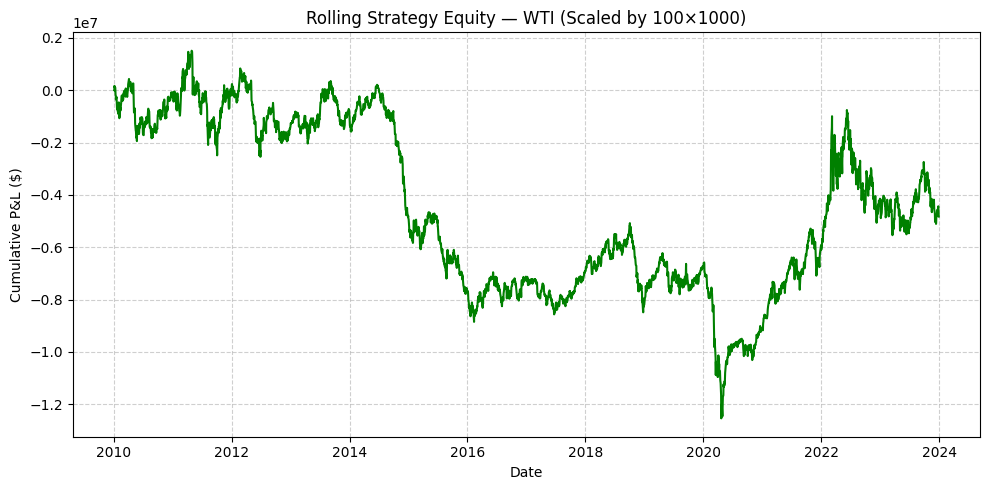

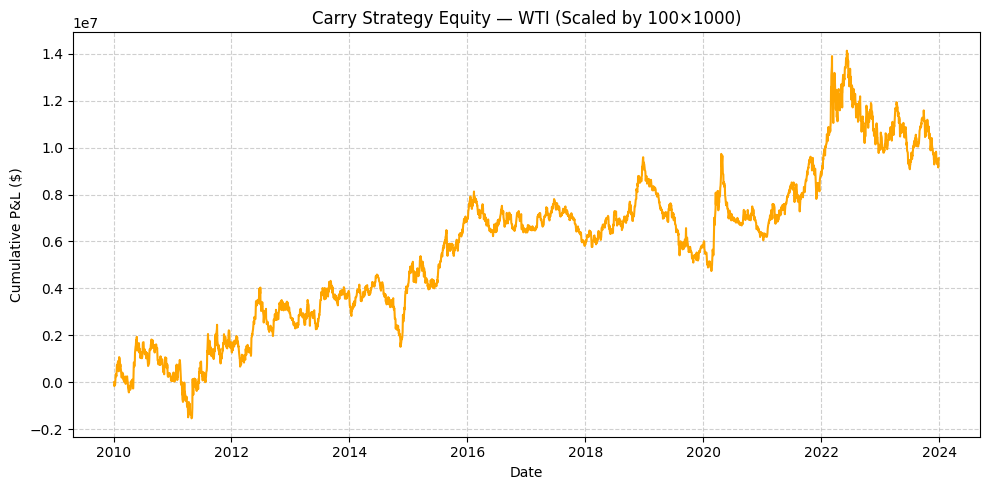

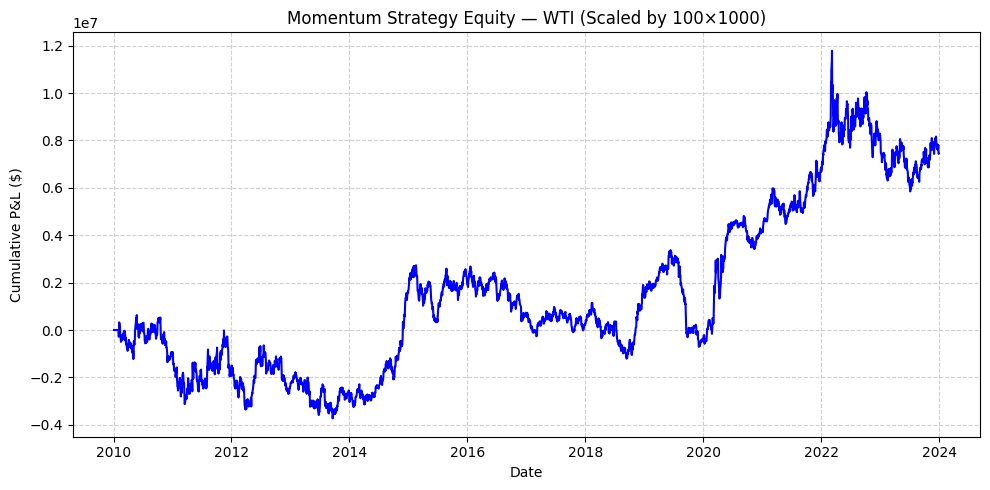

In [416]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Run all strategies ---
rolled_df = rolled  # from your rolling_pnl() output

# Ensure rolling equity line exists
if "equity_line" not in rolled_df.columns:
    rolled_df["equity_line"] = rolled_df["daily_pnl"].cumsum()

carry_df = carry(
    prices=wti_df,
    rolled_df=rolled_df,
    front_col="F1",
    end_col="F4",
    t_cost=0.01,
    epsilon=0.00,
)

momentum_df = momentum(
    prices=wti_df,
    rolled_df=rolled_df,
    front_col="F1",
    short_ma=1,
    long_ma=20,
    t_cost=0.01,
    epsilon=0.00,
)

# --- Scale by actual exposure (100 contracts × 1000 units = 100,000) ---
scale_factor = 100 * 1000

rolled_df["equity_line_scaled"] = rolled_df["equity_line"] * scale_factor
carry_df["equity_line_scaled"] = carry_df["equity_line"] * scale_factor
momentum_df["equity_line_scaled"] = momentum_df["equity_line"] * scale_factor

# --- Plot each strategy separately ---
plt.figure(figsize=(10, 5))
plt.plot(rolled_df.index, rolled_df["equity_line_scaled"], color="green", linewidth=1.5)
plt.title("Rolling Strategy Equity — WTI (Scaled by 100×1000)")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(carry_df.index, carry_df["equity_line_scaled"], color="orange", linewidth=1.5)
plt.title("Carry Strategy Equity — WTI (Scaled by 100×1000)")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(momentum_df.index, momentum_df["equity_line_scaled"], color="blue", linewidth=1.5)
plt.title("Momentum Strategy Equity — WTI (Scaled by 100×1000)")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
